# NLP Project - Jonas Luerkens & Esther Kaltwasser

## Setup

In [ ]:
# Enable access to the drive folder

from google.colab import drive
drive.mount('/content/drive')

# Set path to project directory

project_directory = '/content/drive/MyDrive/Colab\ Notebooks/NLP'

# Go to project directory

%cd /content/drive/MyDrive/Colab\ Notebooks/NLP

# Install requirements

#!pip install -r $project_directory/requirements.txt

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/NLP'
/content


<>:8: SyntaxWarning: invalid escape sequence '\ '
<>:8: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2483971344.py:8: SyntaxWarning: invalid escape sequence '\ '
  project_directory = '/content/drive/MyDrive/Colab\ Notebooks/NLP'


In [ ]:
# Import required libraries

from datapreparation import load_and_prepare_data
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
import torch
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from datasets import Dataset

ModuleNotFoundError: No module named 'datapreparation'

In [ ]:
# Load data

train_ds, val_ds, test_ds, label_list, label2id, id2label = load_and_prepare_data()

Label distribution (train):
Counter({'Technical Support': 6476, 'Customer Service': 3471, 'Billing and Payments': 2307, 'Sales and Pre-Sales': 655, 'General Inquiry': 340})


In [ ]:
# Load the models and tokenizer for task 1 and 2

distilgpt2_model = AutoModelForCausalLM.from_pretrained("distilgpt2")
gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2")

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2") # Same tokenizer as distilgpt2
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token

Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
# HIER SET DEVICE

In [ ]:
# Metrics can vary across runs due to stochastic training;
# Setting seeds helps ensure that reported results can be replicated
# It fixes the random number generators so the model initializes and trains in the same way each time

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Agent 1: Routing with prompting using GPT-2 (frozen model)

### Prompt function and prompt
Here we define the few-shot prompt for the model. It includes one short, precise example for one email for each department.

In [ ]:
# Few-shot learning prompt (1 email per department)

prompt = (
    "Classify the email ONLY into the following categories: Technical Support, Customer Service, Billing and Payments, Sales and Pre-Sales, General Inquiry.\n\n"
    "Subject: Return item | Body: I want to send this product back. -> Department: Customer Service\n"
    "Subject: Invoice missing | Body: I need my bill for July. -> Department: Billing and Payments\n"
    "Subject: Discount inquiry | Body: Do you have bulk pricing? -> Department: Sales and Pre-Sales\n"
    "Subject: Opening hours | Body: When are you open? -> Department: General Inquiry\n"
    "Subject: Internet down | Body: My router is not working. -> Department: Technical Support\n"
)

Now we define the a function that gets an email subject and body and builds the prompt by adding the email content after the few-shot example prompt.

In [ ]:
# Prompt building function

def build_prompt(subject: str, body: str) -> str:
    few_shot = prompt

    return (
        few_shot
        + "Subject: " + (subject or "") + " | "
        + "Body: " + (body or "") + " -> "
        + "Department:"
    )

### Email Routing Function
Next, we define the email routing function that gets the model it should use for routing and the email it should route. It builds the prompt using the build_prompt function to build the prompt, tokenizes it and then lets the model generate the output. Afterwards, it only extracts the corresponding department from the output and returns that.

In [ ]:
# Email routing function, takes an email dict and returns the predicted department

def route_email(model, dict_email):

    if dict_email is None:
        raise ValueError("Email is None")

    # Cut the email subject and body to a reasonable length

    subject = (dict_email.get("subject") or "")[:200]
    body = (dict_email.get("body") or "")[:1200]

    # Build the prompt consisting of the few-shoot examples and the email that should be routed

    prompt = build_prompt(subject, body)

    # Tokenize the prompt

    inputs = tokenizer_gpt(prompt, return_tensors="pt")

    # Move inputs to same device as output

    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=5, # Generate at most 5 tokens
            do_sample=False, # Determenistic decoding, no sampling
            num_beams=3, # Use beam search with 3 beams to explore multiple best continuations
            eos_token_id=tokenizer_gpt.eos_token_id,
            pad_token_id=tokenizer_gpt.eos_token_id, # TODO
        )

    # Generate output

    gen = tokenizer_gpt.decode(
        out[0][inputs["input_ids"].shape[1]:],
        skip_special_tokens=True
    ).strip()

    # Postprocess the output to extract the department

    if "Department:" in gen:
        gen = gen.split("Department:", 1)[1].strip()

    ALLOWED = [
        "Technical Support",
        "Customer Service",
        "Billing and Payments",
        "Sales and Pre-Sales",
        "General Inquiry",
    ]
    for d in ALLOWED:
        if gen.startswith(d):
            return d

    # Default to General Inquiry if no valid department found in the generated output
    return "General Inquiry"


### Evaluation Function
The evaluation function runs through the whole test set and routes each email. During the runthrough it creates a confusion matrix from which it can also calculated the accuracy and F1 macro value

In [ ]:
def evaluate_model(model):

  LABELS = [
      "Technical Support",
      "Sales and Pre-Sales",
      "Billing and Payments",
      "Customer Service",
      "General Inquiry",
  ]

  label_to_idx = {l: i for i, l in enumerate(LABELS)}
  n = len(LABELS)

  confusion = np.zeros((n, n), dtype=int)

  # Route every email in the test dataset and update the confusion matrix
  for email in test_ds:
      y_true = label_to_idx[email["queue"]]
      y_pred = label_to_idx[route_email(model, email)]
      confusion[y_true, y_pred] += 1

  # Compute the accuracy
  accuracy = np.trace(confusion) / confusion.sum()

  # Compute the Macro F1 score
  eps = 1e-12
  f1s = []

  for i in range(n):
      tp = confusion[i, i]
      fp = confusion[:, i].sum() - tp
      fn = confusion[i, :].sum() - tp

      precision = tp / (tp + fp + eps)
      recall = tp / (tp + fn + eps)
      f1s.append(2 * precision * recall / (precision + recall + eps))

  macro_f1 = float(np.mean(f1s))

  # Put out the accuracy, macro F1 and the confusion matrix as a heatmap
  print(f"Accuracy:  {accuracy:.2%}")
  print(f"Macro F1:  {macro_f1:.3f}")

  plt.figure(figsize=(6, 5))
  sns.heatmap(
      confusion,
      annot=True,
      fmt="d",
      cmap="Blues",
      xticklabels=LABELS,
      yticklabels=LABELS,
  )

  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.show()


### Evaluation
Here we call the previously defined evaluation funcion on both model to compute the performance results for the first task

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Accuracy:  38.38%
Macro F1:  0.179


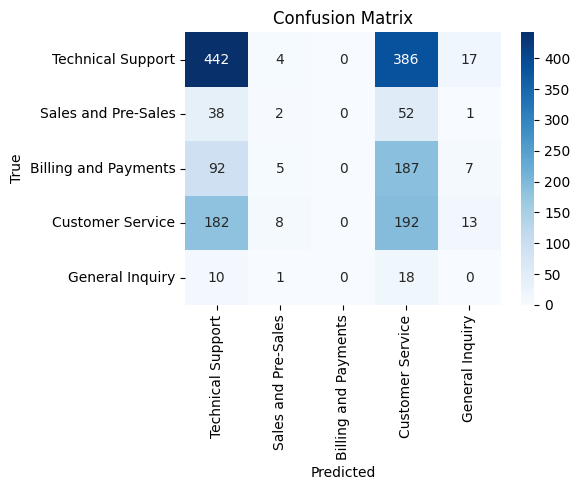

Accuracy:  20.04%
Macro F1:  0.151


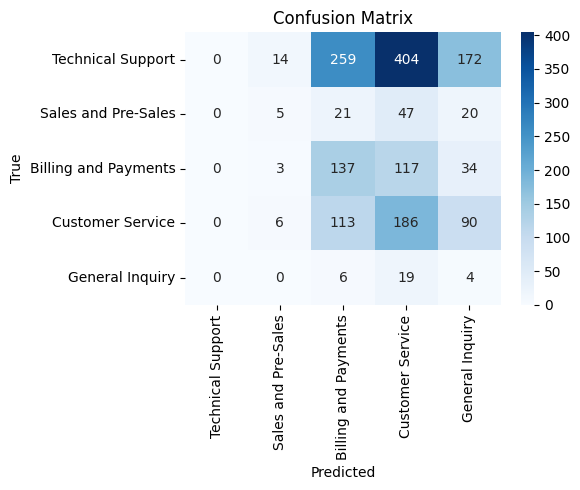

In [ ]:
evaluate_model(distilgpt2_model)
evaluate_model(gpt2_model)


## Agent 2: Routing with fine-tuning (LoRA) on GPT-2 and DistilGPT2

### LoRa configuration
Here we determine the configurations for the LoRA

In [ ]:
# Configure the Lora

lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8, # Rank of the LoRA update matrices (higher = more capacity, more trainable params)
    lora_alpha=16,# Scaling factor for LoRA updates (controls how strongly LoRA affects the base weights)
    lora_dropout=0.05, # Dropout applied to LoRA layers during training (helps reduce overfitting)
    target_modules=["c_attn", "c_proj"],  # Apply LoRA only to these GPT-2 attention/projection layers
    bias="none", # Do not train/add bias parameters (keeps the number of trainable params smaller)
)


### Model initialization function
This function initiates the model for training. It gets a model name and first loads the pretrained model and sets the pad/eos token IDs to match the tokenizer to avoid token-mismatch issues during batching and loss computation Then it wrap the model with PEFT LoRA adapters and sets it to training mode. The model is the returned

In [ ]:
def initiate_model_for_training(model_name):

  model = AutoModelForCausalLM.from_pretrained(model_name)

  model.config.pad_token_id = tokenizer_gpt.pad_token_id
  model.config.eos_token_id = tokenizer_gpt.eos_token_id

  model = get_peft_model(model, lora_config)

  model.train()

  return model

### Data preprocessing functions
The tokenize function formats each email into a prompt–target pair, tokenizes both parts, truncates to a fixed maximum length (256 tokens), and masks the prompt tokens in the labels so that the model is trained to predict only the classification label in a causal language modeling setup.


In [ ]:
def tokenize(email):

    # Truncate subject and body to limit extremely long inputs
    # (helps control total sequence length and memory usage)
    subject = str(email["subject"])[:200]
    body = str(email["body"])[:1200]
    label = str(email["label"]).strip()

    # Build the prompt
    prompt = build_prompt(subject, body)

    # The target is the gold label followed by EOS token.
    # Leading space ensures proper tokenization for GPT-style models.
    target = " " + label + tokenizer_gpt.eos_token

    # Tokenize prompt and target separately without adding extra special tokens
    # (we control EOS manually)
    prompt_ids = tokenizer_gpt(prompt, add_special_tokens=False)["input_ids"]
    target_ids = tokenizer_gpt(target, add_special_tokens=False)["input_ids"]

    # Ensure total length does not exceed model limit (256 tokens here)
    # We reserve space for the target and truncate the prompt if needed
    max_prompt_len = 256 - len(target_ids)

    if max_prompt_len < 1:
        # If the target itself exceeds max length,
        # truncate the target and discard the prompt
        target_ids = target_ids[:256]
        prompt_ids = []
    else:
        # Otherwise truncate the prompt to fit within max length
        prompt_ids = prompt_ids[:max_prompt_len]

    # Final input is prompt followed by target (standard causal LM setup)
    input_ids = prompt_ids + target_ids

    # Attention mask: 1 for real tokens (no padding used here)
    attention_mask = [1] * len(input_ids)

    # Labels:
    # - Ignore prompt tokens in the loss by setting them to -100
    # - Compute loss only on target tokens (the label)
    labels = [-100] * len(prompt_ids) + target_ids

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }


The preprocessing function gets a dataset and first standardizes the dataset by renaming the queue column to label. It then removes all unnecessary columns and tokenizes the data into model-ready inputs (input IDs, attention masks, and labels) for causal language model training. Then it returns the ready dataset

In [ ]:
# Renaming function

def rename_queue_to_label(ex):
    lab = ex["queue"]
    if lab is None:
        lab = ""
    return {"label": str(lab).strip()}

# Preprocessing function

def preprocess_for_training(dataset):

  keep_cols = ["subject", "body", "queue"]
  dataset = dataset.remove_columns([c for c in dataset.column_names if c not in keep_cols])
  dataset = dataset.map(rename_queue_to_label)
  dataset = dataset.remove_columns(['queue'])
  tokenized_dataset = dataset.map(tokenize, remove_columns=dataset.column_names)

  return dataset

### Training configuration
We configure the training arguments here. We used a per-device batch size of 2 with gradient accumulation over 8 steps (effective batch size = 16). The model was trained for 10 epochs with a learning rate of 3e-4. Evaluation and checkpointing were conducted at the end of each epoch, and up to 10 checkpoints were retained. This enabled the comparison of the performance over epochs

In [ ]:
# Set the training arguments

args = TrainingArguments(
    output_dir='output_training',
    per_device_train_batch_size=2, # Batch size per GPU/CPU device
    gradient_accumulation_steps=8,  # Accumulate gradients to simulate a larger batch (effective batch = 2*8 = 16)
    num_train_epochs=10,
    learning_rate=3e-4,

    save_strategy="epoch",
    eval_strategy="epoch",
    save_total_limit=10,
    report_to="none"
)

### Define batching function

In [ ]:
# Define the batching function

def collate_fn(batch):
    pad_id = tokenizer_gpt.pad_token_id

    # Find the longest sequence and pad everything else in the batch to the same size

    max_len = max(len(x["input_ids"]) for x in batch)

    input_ids, attention_mask, labels = [], [], []
    for x in batch:
        ids, att, lab = x["input_ids"], x["attention_mask"], x["labels"]
        pad_len = max_len - len(ids)
        input_ids.append(ids + [pad_id] * pad_len)
        attention_mask.append(att + [0] * pad_len)
        labels.append(lab + [-100] * pad_len)

    return {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
        "labels": torch.tensor(labels, dtype=torch.long),
    }

### Define initialization function for trainer

In [ ]:
def initialize_trainer(model, train_dataset, eval_dataset):

  trainer = Trainer(
      model=model,
      args=args,
      train_dataset=train_dataset,
      eval_dataset=eval_dataset,
      data_collator=collate_fn
  )


### Training

In [ ]:
# Initialize models

model_for_training_distilgpt2 = initiate_model_for_training("distilgpt2")
model_for_training_gpt2 = initiate_model_for_training("gpt2")

# Preprocess and tokenize datasets
tokenized_train = preprocess_for_training(train_ds)
tokenized_val = preprocess_for_training(val_ds)

# Initialize trainer

trainer_gpt2 = initialize_trainer(model_for_training_gpt2, tokenized_train, tokenized_val)
trainer_distilgpt2 = initialize_trainer(model_for_training_distilgpt2, tokenized_train, tokenized_val)

# Train models

#trainer_gpt2.train()
#model_fine_tuned_gpt2 = trainer_gpt2.model

#trainer_distilgpt2.train()
#model_fine_tuned_distilgpt2 = trainer_distilgpt2.model


Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:78: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'distilgpt2' to 'gpt2'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(


Map:   0%|          | 0/13249 [00:00<?, ? examples/s]

Map:   0%|          | 0/13249 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

### Load trained models from directory

In [ ]:
model_fine_tuned_gpt2 = PeftModel.from_pretrained(gpt2_model, 'gpt2_fine-tuned')
model_fine_tuned_gpt2.eval()

model_fine_tuned_distilgpt2 = PeftModel.from_pretrained(distilgpt2_model, 'distilgpt2_fine-tuned')
model_fine_tuned_distilgpt2.eval()

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:285: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-5): 6 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D(nf=2304, nx=768)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
            

### Evaluation

In [ ]:
evaluate_model(model_fine_tuned_gpt2)
evaluate_model(model_fine_tuned_distilgpt2)